In [6]:
import pandas as pd
import pandas as pd
import numpy as np
import re

import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report

filtered = pd.read_csv('clean_data.csv')

In [1]:
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def extract_text_features(text):
    tokens = word_tokenize(text)
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    avg_token_length = sum(len(token) for token in tokens) / num_tokens if num_tokens > 0 else 0
    num_stopwords = sum(1 for token in tokens if token.lower() in stop_words)
    stopword_rate = num_stopwords / num_tokens if num_tokens > 0 else 0
    num_punct = sum(1 for token in tokens if token in string.punctuation)
    punct_rate = num_punct / num_tokens if num_tokens > 0 else 0

    pos_counts = dict(nltk.FreqDist(tag for word, tag in pos_tag(tokens)))
    num_nouns = sum(pos_counts.get(tag, 0) for tag in ['NN', 'NNS', 'NNP', 'NNPS'])
    noun_rate = num_nouns / num_tokens if num_tokens > 0 else 0
    num_verbs = sum(pos_counts.get(tag, 0) for tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'])
    verb_rate = num_verbs / num_tokens if num_tokens > 0 else 0

    return pd.Series({
        'token_count': num_tokens,
        'avg_token_length': avg_token_length,
        'stopword_rate': stopword_rate,
        'punctuation_rate': punct_rate,
        'noun_rate': noun_rate,
        'verb_rate': verb_rate,
        'unique_word_ratio': num_unique_tokens / num_tokens if num_tokens > 0 else 0
    })


In [7]:
text_features = filtered['clean_text'].apply(extract_text_features)
filtered = pd.concat([filtered, text_features], axis=1)


In [ ]:
filtered.groupby('label')[['token_count', 'avg_token_length', 'stopword_rate', 'punctuation_rate', 'noun_rate', 'verb_rate', 'unique_word_ratio']].mean().T

label,0,1
token_count,116.236094,105.180781
avg_token_length,6.910943,7.359163
stopword_rate,0.000462,0.000122
punctuation_rate,0.000000,0.000001
noun_rate,0.557437,0.580590
verb_rate,0.100388,0.105753
unique_word_ratio,0.733973,0.723420


# Importing necessary libraries

# Descriptive stats

### Top n-grams

In [4]:
def top_ngram_calculator(data, ngram_n, top_k):
    
    texts = data['clean_text']

    # Initialize vectorizer (unigram or bigram)
    vec = CountVectorizer(ngram_range=(ngram_n, ngram_n), stop_words='english', max_features=5000, max_df=0.8, min_df = 20)
    X = vec.fit_transform(texts)

    # Sum counts per n-gram
    ngram_counts = pd.DataFrame(X.sum(axis=0), columns=vec.get_feature_names_out()).T
    ngram_counts.columns = ['count']
    top_ngrams_combined = ngram_counts.sort_values('count', ascending=False).head(top_k)
    
    return top_ngrams_combined

In [8]:
human = filtered[filtered.label == 0]
ai = filtered[filtered.label == 1]

# top unigrams
uni_total = top_ngram_calculator(filtered, 1, 20)
uni_human = top_ngram_calculator(human, 1, 20)
uni_ai = top_ngram_calculator(ai, 1, 20)

# top bigrams
bi_total = top_ngram_calculator(filtered, 2, 10)
bi_human = top_ngram_calculator(human, 2, 10)
bi_ai = top_ngram_calculator(ai, 2, 10)

# top trigrams
tri_total = top_ngram_calculator(filtered, 3, 10)
tri_human = top_ngram_calculator(human, 3, 10)
tri_ai = top_ngram_calculator(ai, 3, 10)

In [ ]:
uni_ai

,count
study,180.599130
method,177.458449
model,176.066696
galaxy,164.715093
approach,162.361845
use,155.915395
result,151.136030
propose,148.379060
provide,141.786533
star,141.770164


In [ ]:
def unique_token_counter(data):
    texts = data['clean_text']

    # Initialize CountVectorizer for unigrams
    vec = CountVectorizer(ngram_range=(1, 1), stop_words='english', max_df=1, min_df=1)
    X = vec.fit_transform(texts)

    # Extract unique token names
    unique_tokens = vec.get_feature_names_out()
    num_unique_tokens = len(unique_tokens)

    return num_unique_tokens, unique_tokens  # You can return just num_unique_tokens if you only need the count


In [ ]:
unique_token_counter(ai)

(12110,
 array(['00', '00000018', '0000012', ..., 'zy', 'zz', 'µwcmk'],
       shape=(12110,), dtype=object))

### Word count

In [ ]:
filtered.word_count.describe()

count    12800.000000
mean       191.880703
std         88.157998
min         29.000000
25%        120.000000
50%        182.000000
75%        260.000000
max        594.000000
Name: word_count, dtype: float64

In [ ]:
filtered.groupby('label').word_count.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,6400.0,202.399531,94.506857,50.0,122.0,197.5,277.0,594.0
1,6400.0,181.361875,79.950031,29.0,119.0,169.0,245.0,455.0


In [9]:
import textstat

readability_metrics = ['flesch_reading_ease',
                       'flesch_kincaid_grade',
                       'gunning_fog',
                       'smog_index',
                       'dale_chall_readability_score',
                       'automated_readability_index']

for metric in readability_metrics:
    func = getattr(textstat, metric)
    filtered[metric] = filtered['text'].apply(func)


In [10]:
filtered.groupby('label')[readability_metrics].agg(['mean']).T

,label,0,1
flesch_reading_ease,mean,27.978131,19.517069
flesch_kincaid_grade,mean,15.097438,15.998938
gunning_fog,mean,16.304005,16.839977
smog_index,mean,15.791453,16.961141
dale_chall_readability_score,mean,10.761842,10.594428
automated_readability_index,mean,16.652406,17.231328


In [19]:
from scipy.stats import ttest_ind, mannwhitneyu

# Separate the two groups
group_0 = filtered[filtered['label'] == 0]
group_1 = filtered[filtered['label'] == 1]

# List of readability metrics
metrics = [
    'flesch_reading_ease', 
    'flesch_kincaid_grade', 
    'gunning_fog', 
    'smog_index', 
    'dale_chall_readability_score', 
    'automated_readability_index'
]

for metric in metrics:
    stat, p = ttest_ind(group_0[metric], group_1[metric], equal_var=False)
    print(f"{metric}: t-stat={stat:.4f}, p-value={p:.4f}")


flesch_reading_ease: t-stat=34.7682, p-value=0.0000
flesch_kincaid_grade: t-stat=-19.5200, p-value=0.0000
gunning_fog: t-stat=-11.1381, p-value=0.0000
smog_index: t-stat=-22.2817, p-value=0.0000
dale_chall_readability_score: t-stat=9.2436, p-value=0.0000
automated_readability_index: t-stat=-10.6984, p-value=0.0000


c:\Users\User\Documents\egyetem\szakdolgozat\venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6400.
  res = hypotest_fun_out(*samples, **kwds)


flesch_reading_ease | Label 0 | Shapiro-Wilk p = 0.0000


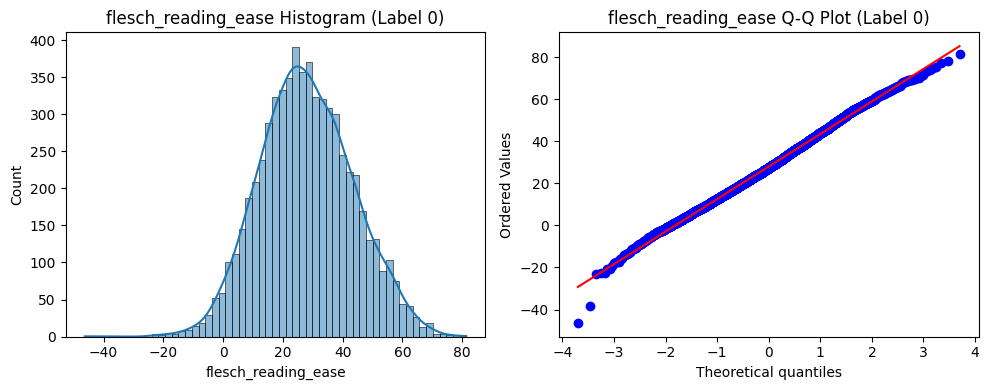

c:\Users\User\Documents\egyetem\szakdolgozat\venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6400.
  res = hypotest_fun_out(*samples, **kwds)


flesch_reading_ease | Label 1 | Shapiro-Wilk p = 0.1433


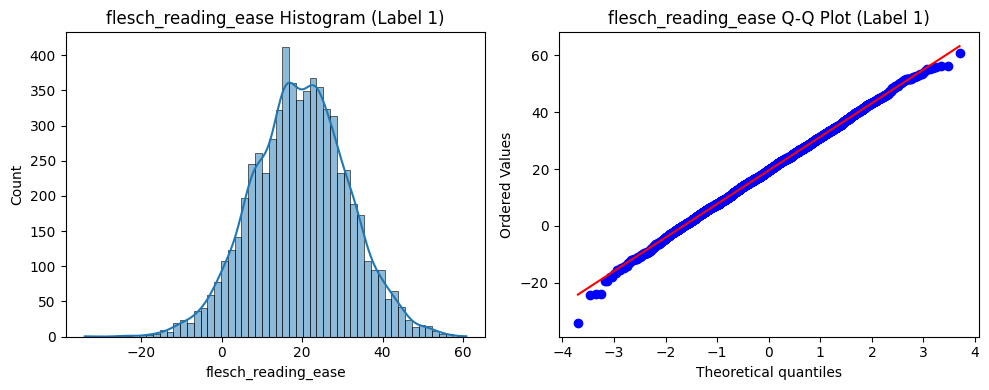

c:\Users\User\Documents\egyetem\szakdolgozat\venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6400.
  res = hypotest_fun_out(*samples, **kwds)


flesch_kincaid_grade | Label 0 | Shapiro-Wilk p = 0.0000


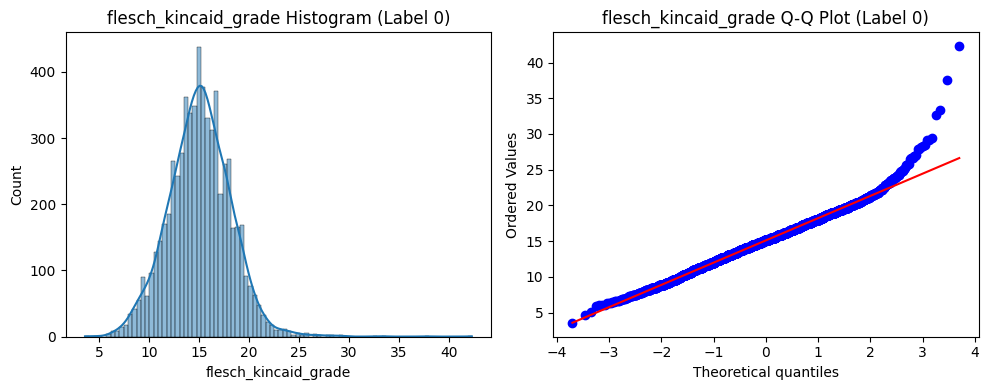

c:\Users\User\Documents\egyetem\szakdolgozat\venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6400.
  res = hypotest_fun_out(*samples, **kwds)


flesch_kincaid_grade | Label 1 | Shapiro-Wilk p = 0.0000


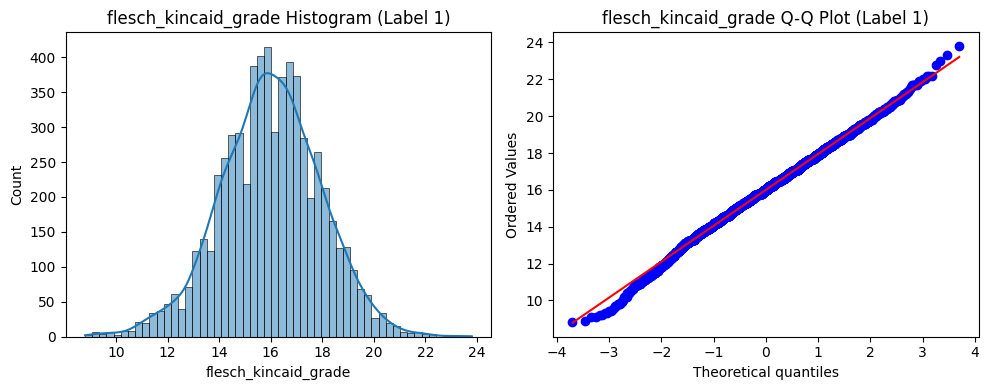

c:\Users\User\Documents\egyetem\szakdolgozat\venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6400.
  res = hypotest_fun_out(*samples, **kwds)


gunning_fog | Label 0 | Shapiro-Wilk p = 0.0000


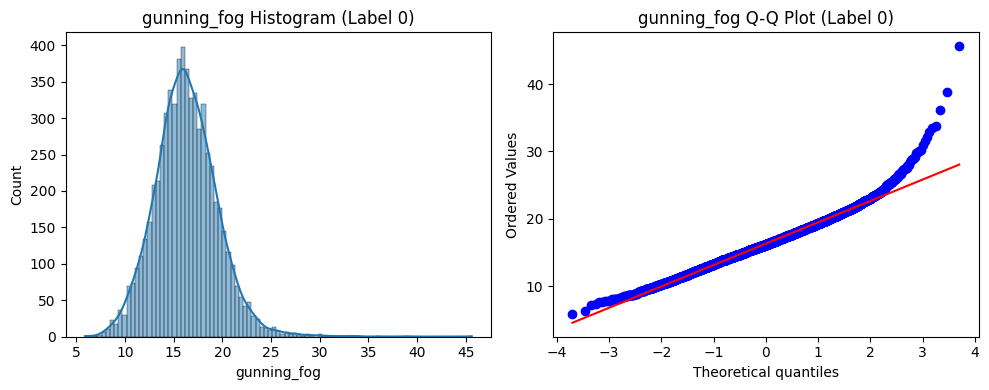

c:\Users\User\Documents\egyetem\szakdolgozat\venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6400.
  res = hypotest_fun_out(*samples, **kwds)


gunning_fog | Label 1 | Shapiro-Wilk p = 0.0002


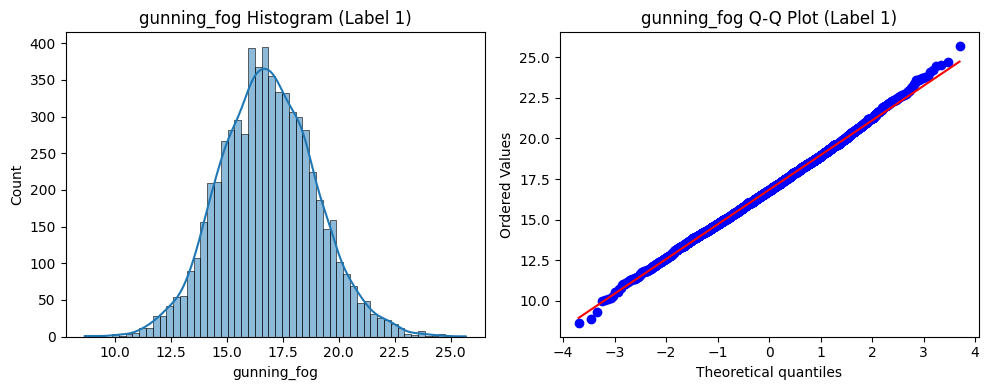

c:\Users\User\Documents\egyetem\szakdolgozat\venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6400.
  res = hypotest_fun_out(*samples, **kwds)


smog_index | Label 0 | Shapiro-Wilk p = 0.0000


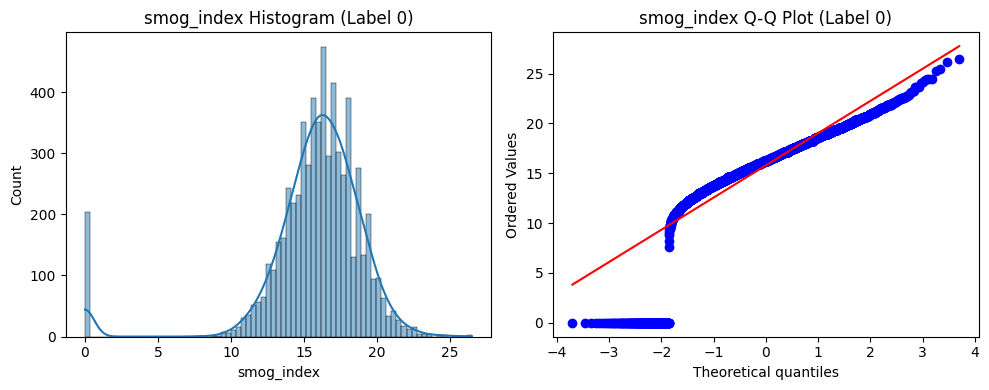

c:\Users\User\Documents\egyetem\szakdolgozat\venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6400.
  res = hypotest_fun_out(*samples, **kwds)


smog_index | Label 1 | Shapiro-Wilk p = 0.0000


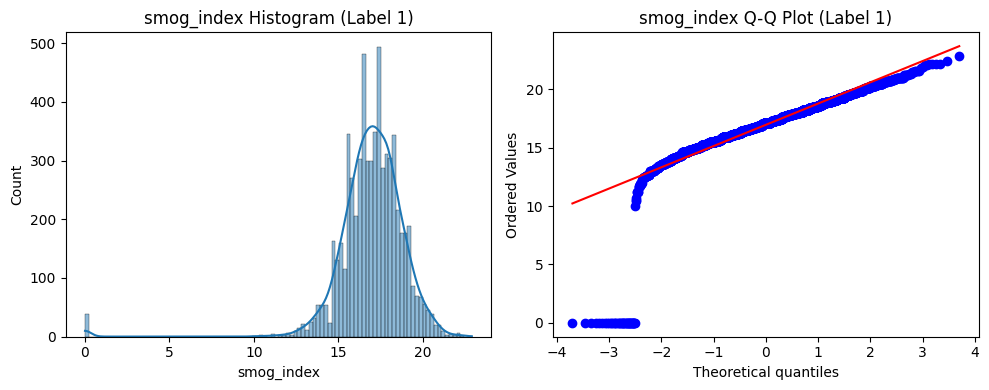

c:\Users\User\Documents\egyetem\szakdolgozat\venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6400.
  res = hypotest_fun_out(*samples, **kwds)


dale_chall_readability_score | Label 0 | Shapiro-Wilk p = 0.0000


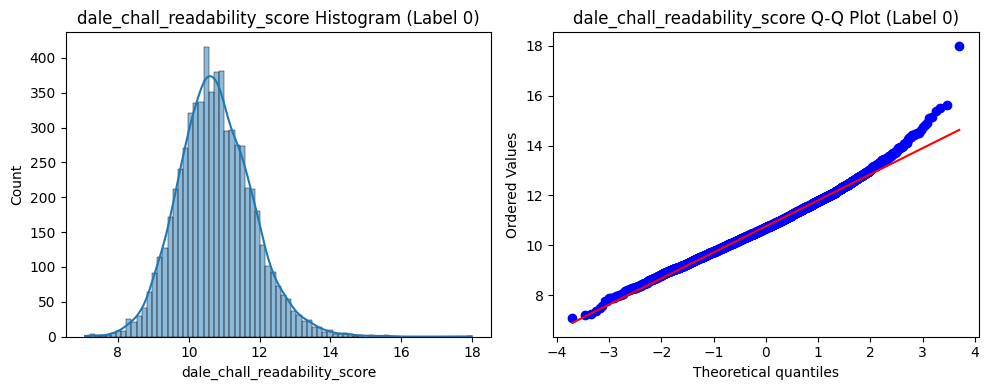

c:\Users\User\Documents\egyetem\szakdolgozat\venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6400.
  res = hypotest_fun_out(*samples, **kwds)


dale_chall_readability_score | Label 1 | Shapiro-Wilk p = 0.0000


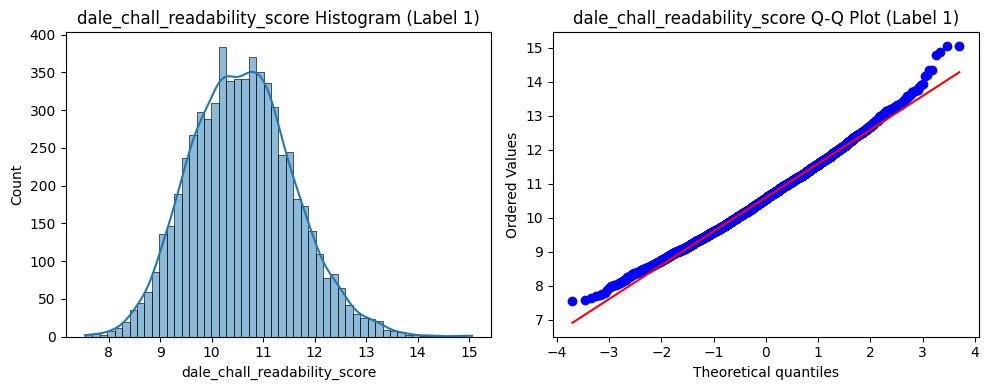

c:\Users\User\Documents\egyetem\szakdolgozat\venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6400.
  res = hypotest_fun_out(*samples, **kwds)


automated_readability_index | Label 0 | Shapiro-Wilk p = 0.0000


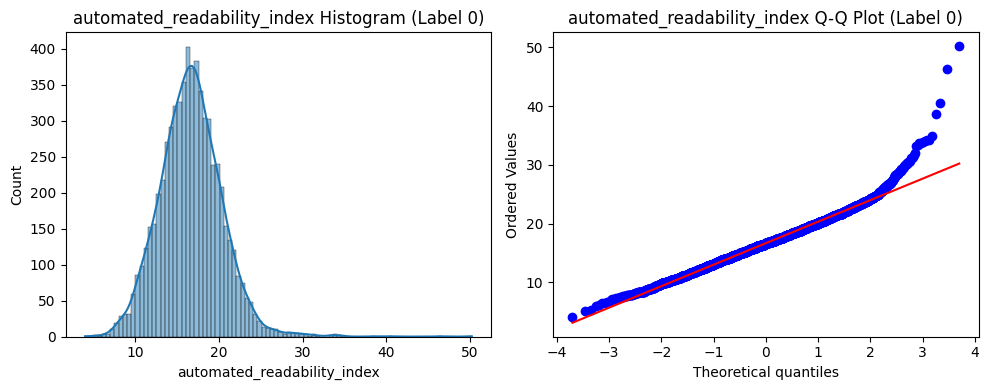

c:\Users\User\Documents\egyetem\szakdolgozat\venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6400.
  res = hypotest_fun_out(*samples, **kwds)


automated_readability_index | Label 1 | Shapiro-Wilk p = 0.0000


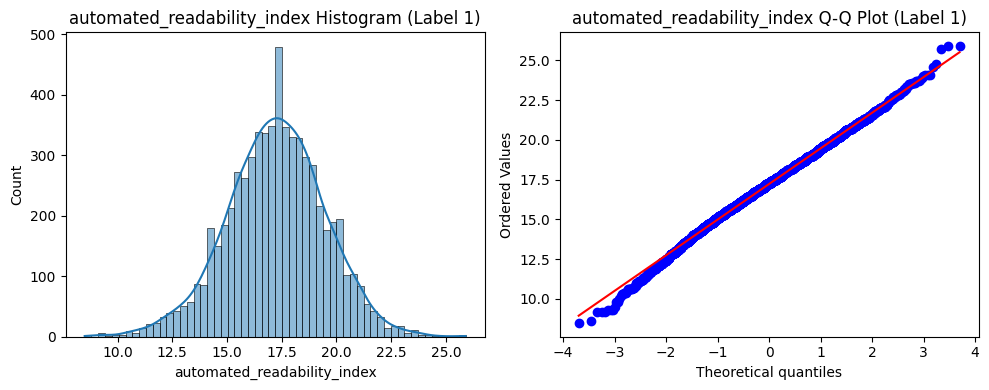

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, probplot

metrics = [
    'flesch_reading_ease', 
    'flesch_kincaid_grade', 
    'gunning_fog', 
    'smog_index', 
    'dale_chall_readability_score', 
    'automated_readability_index'
]

# Loop through metrics and both classes
for metric in metrics:
    for label in [0, 1]:
        data = filtered[filtered['label'] == label][metric]

        # Shapiro-Wilk Test
        stat, p = shapiro(data)
        print(f"{metric} | Label {label} | Shapiro-Wilk p = {p:.4f}")

        # Plot
        plt.figure(figsize=(10, 4))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(data, kde=True)
        plt.title(f"{metric} Histogram (Label {label})")

        # Q-Q Plot
        plt.subplot(1, 2, 2)
        probplot(data, dist="norm", plot=plt)
        plt.title(f"{metric} Q-Q Plot (Label {label})")

        plt.tight_layout()
        plt.show()


In [18]:
from scipy.stats import levene

for metric in metrics:
    group_0 = filtered[filtered['label'] == 0][metric]
    group_1 = filtered[filtered['label'] == 1][metric]
    
    stat, p = levene(group_0, group_1)
    print(f"{metric} | Levene’s test p = {p:.4f}")


flesch_reading_ease | Levene’s test p = 0.0000
flesch_kincaid_grade | Levene’s test p = 0.0000
gunning_fog | Levene’s test p = 0.0000
smog_index | Levene’s test p = 0.0000
dale_chall_readability_score | Levene’s test p = 0.0595
automated_readability_index | Levene’s test p = 0.0000


### Vocabulary richness scores

In [26]:
from lexicalrichness import LexicalRichness

vocab_metrics = ['ttr','rttr', 'yulek', 'simpsond', 'Herdan']

for metric in vocab_metrics:
    filtered[f"{metric}_new"] = filtered['clean_text'].apply(
        lambda text: getattr(LexicalRichness(text), metric)
    )


In [27]:
vocab_metrics_new = ['rttr_new', 'yulek_new', 'simpsond_new', 'Herdan_new']
filtered[vocab_metrics_new].dtypes

filtered.groupby('label')[vocab_metrics_new].mean().T

label,0,1
rttr_new,7.364583,7.030528
yulek_new,98.842639,109.376518
simpsond_new,0.010004,0.011069
Herdan_new,0.929956,0.928010


In [28]:
from scipy.stats import ttest_ind, mannwhitneyu

# Separate the two groups
group_0 = filtered[filtered['label'] == 0]
group_1 = filtered[filtered['label'] == 1]

# List of readability metrics
metrics_2 = ['rttr_new', 'yulek_new', 'simpsond_new', 'Herdan_new']

for metric in metrics_2:
    stat, p = ttest_ind(group_0[metric], group_1[metric], equal_var=False)
    print(f"{metric}: t-stat={stat:.4f}, p-value={p:.4f}")

rttr_new: t-stat=14.9022, p-value=0.0000
yulek_new: t-stat=-11.5871, p-value=0.0000
simpsond_new: t-stat=-11.5213, p-value=0.0000
Herdan_new: t-stat=4.2098, p-value=0.0000
